In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 2, 47, 40, 102677)

In [3]:
with open('./hopsworks_API.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1171609
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='7.840906E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
print(type(today)) 
print(type(weather_fg.date))
# today_str = today.strftime("%Y-%m-%d %H:%M:%S")
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

<class 'datetime.datetime'>
<class 'hsfs.feature.Feature'>
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-25 00:00:00+00:00,19.900000,0.0,1.527351,44.999897,Meizhou
1,2024-11-21 00:00:00+00:00,16.549999,0.2,10.514218,321.952911,Meizhou
2,2024-11-24 00:00:00+00:00,18.549999,0.0,2.099143,30.963696,Meizhou
3,2024-11-22 00:00:00+00:00,18.299999,0.0,8.311245,355.030334,Meizhou
4,2024-11-20 00:00:00+00:00,17.650000,0.6,12.538134,320.826355,Meizhou
5,2024-11-23 00:00:00+00:00,18.450001,0.0,1.835647,348.690094,Meizhou


In [11]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-25 00:00:00+00:00,19.900000,0.0,1.527351,44.999897,Meizhou,133.753677
1,2024-11-21 00:00:00+00:00,16.549999,0.2,10.514218,321.952911,Meizhou,98.162605
2,2024-11-24 00:00:00+00:00,18.549999,0.0,2.099143,30.963696,Meizhou,142.065811
3,2024-11-22 00:00:00+00:00,18.299999,0.0,8.311245,355.030334,Meizhou,89.493835
4,2024-11-20 00:00:00+00:00,17.650000,0.6,12.538134,320.826355,Meizhou,104.352432
5,2024-11-23 00:00:00+00:00,18.450001,0.0,1.835647,348.690094,Meizhou,116.065285


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         6 non-null      datetime64[ns, UTC]
 1   temperature_2m_mean          6 non-null      float32            
 2   precipitation_sum            6 non-null      float32            
 3   wind_speed_10m_max           6 non-null      float32            
 4   wind_direction_10m_dominant  6 non-null      float32            
 5   city                         6 non-null      object             
 6   predicted_pm25               6 non-null      float32            
dtypes: datetime64[ns, UTC](1), float32(5), object(1)
memory usage: 344.0+ bytes


In [15]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
4,2024-11-20 00:00:00+00:00,17.650000,0.6,12.538134,320.826355,Meizhou,104.352432,Sanjiao town,China,5
1,2024-11-21 00:00:00+00:00,16.549999,0.2,10.514218,321.952911,Meizhou,98.162605,Sanjiao town,China,2
3,2024-11-22 00:00:00+00:00,18.299999,0.0,8.311245,355.030334,Meizhou,89.493835,Sanjiao town,China,4
5,2024-11-23 00:00:00+00:00,18.450001,0.0,1.835647,348.690094,Meizhou,116.065285,Sanjiao town,China,6
2,2024-11-24 00:00:00+00:00,18.549999,0.0,2.099143,30.963696,Meizhou,142.065811,Sanjiao town,China,3
0,2024-11-25 00:00:00+00:00,19.900000,0.0,1.527351,44.999897,Meizhou,133.753677,Sanjiao town,China,1


In [16]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 4 to 0
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         6 non-null      datetime64[ns, UTC]
 1   temperature_2m_mean          6 non-null      float32            
 2   precipitation_sum            6 non-null      float32            
 3   wind_speed_10m_max           6 non-null      float32            
 4   wind_direction_10m_dominant  6 non-null      float32            
 5   city                         6 non-null      object             
 6   predicted_pm25               6 non-null      float32            
 7   street                       6 non-null      object             
 8   country                      6 non-null      object             
 9   days_before_forecast_day     6 non-null      int64              
dtypes: datetime64[ns, UTC](1), float32(5), int64(1), objec

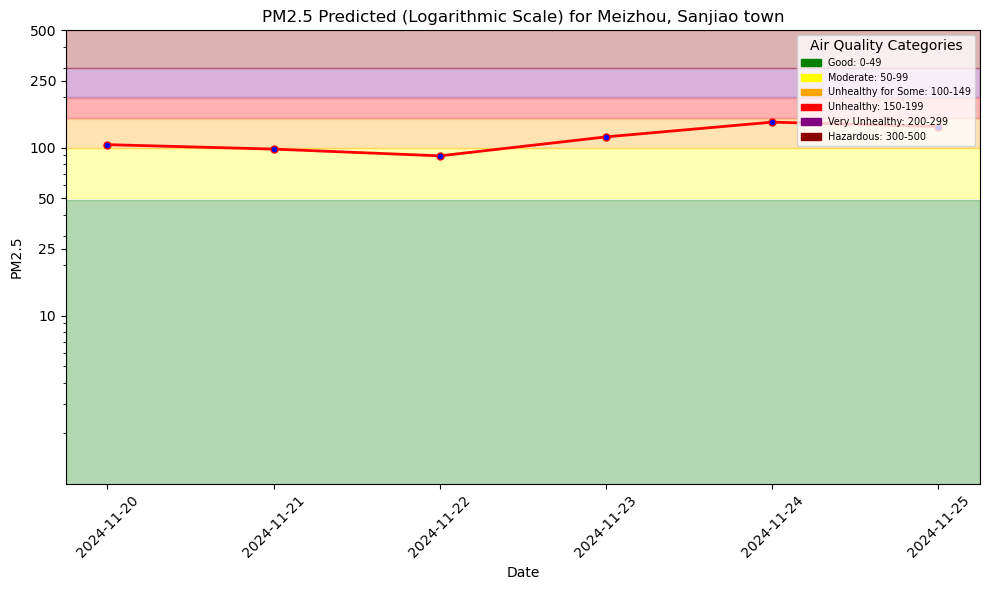

In [17]:
file_path = "./pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [18]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [19]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/6 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1171609/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1c6281f63e0>, None)

In [20]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-25 00:00:00+00:00,19.9,0.0,1.527351,44.999897,Meizhou,133.753677,Sanjiao town,China,1
1,2024-11-16 00:00:00+00:00,24.6,0.0,9.021574,331.389618,Meizhou,115.002296,Sanjiao town,China,1


In [21]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


,date,pm25,country,city,street,url
0,2021-09-22 00:00:00+00:00,47.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341
1,2014-06-15 00:00:00+00:00,91.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341
2,2018-07-10 00:00:00+00:00,75.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341
3,2014-04-12 00:00:00+00:00,114.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341
4,2018-10-29 00:00:00+00:00,85.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341
...,...,...,...,...,...,...
3937,2017-03-23 00:00:00+00:00,63.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341
3938,2020-07-31 00:00:00+00:00,34.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341
3939,2019-11-14 00:00:00+00:00,112.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341
3940,2022-05-05 00:00:00+00:00,83.0,China,Meizhou,Sanjiao town,https://api.waqi.info/feed/@4341


In [22]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-16 00:00:00+00:00,115.002296,57.0


In [23]:
preds_df

,date,predicted_pm25
0,2024-11-25 00:00:00+00:00,133.753677
1,2024-11-16 00:00:00+00:00,115.002296


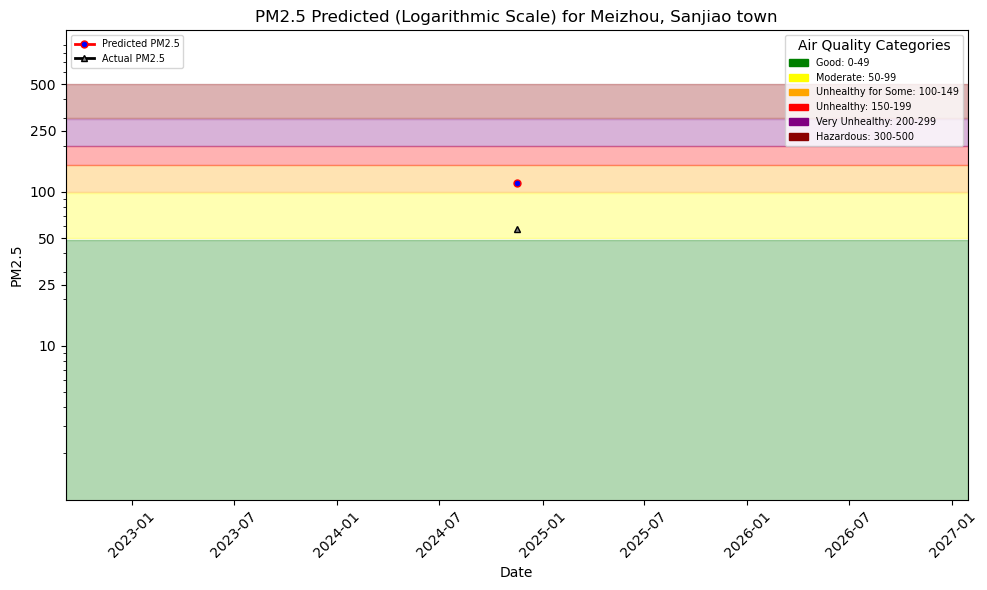

In [28]:
file_path = "./pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()